# Crawl JC Odds

In [162]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import re
import time
from tqdm import tqdm_notebook as tqdm
from datetime import datetime, timedelta
import json

driver = webdriver.Chrome()
start_url = "http://bet.hkjc.com/football/default.aspx?url=/football/schedule/schedule.aspx&lang=en"
driver.get(start_url)
driver.switch_to_frame(driver.find_element_by_tag_name("iframe"))

from_date = "01"
from_month = "08"
from_year = "2017"

to_date = "31"
to_month = "05"
to_year = "2018"

with open('./{}-{}/team_instances_table.json'.format(from_year, to_year),'r') as fp:
    team_table = json.load(fp)

In [163]:
def reloadIframe(webdriver):
    webdriver.switch_to_default_content()
    webdriver.switch_to_frame(webdriver.find_element_by_tag_name("iframe"))

In [164]:
results_dividends_button = driver.find_element_by_xpath("//*[@id=\"betToolsTxt_2\"]")
results_dividends_button.click()
match_results_button = driver.find_element_by_xpath("//*[@id=\"betToolsMenu_2\"]/table/tbody/tr/td/table/tbody/tr[1]/td[2]/a")
match_results_button.click()
time.sleep(2)

jc_match_table = {}
ttl_cnt = 1

for team_id, team_info in team_table.items():
    jc_team = team_info['jc_name']
    while True:
        try:
            reloadIframe(driver)
            time.sleep(1)
            
            # Select desired start date
            from_date_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Fday\"]"))
            from_month_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Fmonth\"]"))
            from_year_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Fyear\"]"))

            change_from_date = from_date_list.select_by_value(from_date)
            change_from_month = from_month_list.select_by_value(from_month)
            change_from_year = from_year_list.select_by_value(from_year)
            
            # Select desired end date
            to_date_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Tday\"]"))
            to_month_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Tmonth\"]"))
            to_year_list = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_Tyear\"]"))

            change_to_date = to_date_list.select_by_value(to_date)
            change_to_month = to_month_list.select_by_value(to_month)
            change_to_year = to_year_list.select_by_value(to_year)
            
            # Select desired JC team name
            select_team = Select(driver.find_element_by_xpath("//*[@id=\"ctl00_cm_srch_DDL_TeamList\"]"))
            select_team.select_by_visible_text(jc_team)
            
            # Click "search"
            driver.find_element_by_xpath("//*[@id=\"btn_search\"]").click()
            time.sleep(1)
            
            # Map each match to Whoscored match table and record the JC odds report link
            reloadIframe(driver)
            time.sleep(1)
            
            page_a_tag = driver.find_elements_by_xpath("//*[@id=\"footballmaincontent\"]/table/tbody/tr[4]/td/div/div[2]/a")
            page_cnt = 1
            while True:
                all_matches = driver.find_elements_by_xpath("//*[@id=\"ctl00_cm_tdMatches\"]/table/tbody/tr")
                series_a_matches = []
                
                for match in all_matches:
                    matchLeague = match.find_element_by_class_name("matchLeague").find_element_by_tag_name('img').get_attribute("title")
                    if matchLeague == "Italian Division 1":
                        series_a_matches.append(match)
                print(">>> {} Crawling team: {}, page: {}, no of matches: {}".format(ttl_cnt,jc_team, page_cnt, len(series_a_matches)))
                
                for match in series_a_matches:
                    matchTeam = match.find_element_by_class_name("matchTeam").text
                    home_team = matchTeam.split(" vs ")[0]
                    away_team = matchTeam.split(" vs ")[1]
                    
                    matchDate = match.find_element_by_class_name("matchDate").text
                    #jc_match_date = datetime.strptime(matchDate, "%d/%m/%Y")
                    
                    matchOdds = match.find_element_by_class_name("matchOdds").find_element_by_tag_name("a").get_attribute("href")
                    
                    jc_match_id = "{},{},{}".format(home_team,away_team,matchDate)
                    
                    if jc_match_id not in jc_match_table:
                        jc_match_table[jc_match_id] = {}
                        jc_match_table[jc_match_id]["odds_link"] = matchOdds
                    
                    
                if page_a_tag[-1].text != "Next":
                    break
                
                page_a_tag[-1].click()
                time.sleep(1)
                page_cnt += 1
                reloadIframe(driver)
                time.sleep(1)
                while True:
                    try:
                        page_a_tag = driver.find_elements_by_xpath("//*[@id=\"footballmaincontent\"]/table/tbody/tr[4]/td/div/div[2]/a")
                        break
                    except Exception as e:
                        print("Finding next page button...")
                        print(e)
                        time.sleep(1)
            ttl_cnt += 1          
            break
            
        except Exception as e:
            print(e)
            time.sleep(1)
print(">>> finished.")

>>>1 Crawling team: SPAL, page: 1, no of matches: 19
>>>1 Crawling team: SPAL, page: 2, no of matches: 10
>>>2 Crawling team: Sassuolo, page: 1, no of matches: 18
>>>2 Crawling team: Sassuolo, page: 2, no of matches: 11
>>>3 Crawling team: Cagliari, page: 1, no of matches: 20
>>>3 Crawling team: Cagliari, page: 2, no of matches: 9
>>>4 Crawling team: Sampdoria, page: 1, no of matches: 18
>>>4 Crawling team: Sampdoria, page: 2, no of matches: 12
>>>5 Crawling team: Genoa, page: 1, no of matches: 18
>>>5 Crawling team: Genoa, page: 2, no of matches: 12
>>>6 Crawling team: Benevento, page: 1, no of matches: 20
>>>6 Crawling team: Benevento, page: 2, no of matches: 9
>>>7 Crawling team: Roma, page: 1, no of matches: 16
>>>7 Crawling team: Roma, page: 2, no of matches: 14
>>>8 Crawling team: Fiorentina, page: 1, no of matches: 18
>>>8 Crawling team: Fiorentina, page: 2, no of matches: 11
>>>9 Crawling team: Crotone, page: 1, no of matches: 19
>>>9 Crawling team: Crotone, page: 2, no of matc

In [165]:
subdriver = webdriver.Chrome()

ttl_cnt = 1
print("Total number of match: {}.".format(len(jc_match_table)))
for jc_match_id, jc_match_details in jc_match_table.items():
    print(">>>{} Crawling {}...".format(ttl_cnt, jc_match_id))
    odds_link = jc_match_details['odds_link']
    subdriver.get(odds_link)
    time.sleep(2)
    
    tblResults = subdriver.find_elements_by_class_name("tblResults")

    # Filter tblResults
    for tblResult in tblResults:
        try:
            pool_type = tblResult.get_attribute("poolkey")
            if (pool_type == "HAD"):
                home_full_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[1]").text
                draw_full_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[2]").text
                away_full_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[3]").text
                jc_full_odds = ",".join([home_full_odds, draw_full_odds, away_full_odds])
            elif (pool_type == "FHA"):
                home_half_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[1]").text
                draw_half_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[2]").text
                away_half_odds = tblResult.find_element_by_xpath("tbody/tr[3]/td[3]").text
                jc_half_odds = ",".join([home_half_odds, draw_half_odds, away_half_odds])
        except Exception as e:
            print(e)
            
    jc_match_table[jc_match_id]["jc_full_odds"] = jc_full_odds
    jc_match_table[jc_match_id]["jc_half_odds"] = jc_half_odds
    
    ttl_cnt += 1
print(">>> finished.")
driver.close()
subdriver.close()

Total number of match: 294.
>>>1 Crawling Chievo,Juventus,28/01/2018...
>>>2 Crawling Chievo,Lazio,28/08/2017...
>>>3 Crawling Genoa,Cagliari,04/03/2018...
>>>4 Crawling Cagliari,Crotone,10/09/2017...
>>>5 Crawling Sassuolo,Juventus,17/09/2017...
>>>6 Crawling Juventus,Benevento,05/11/2017...
>>>7 Crawling AC Milan,Crotone,06/01/2018...
>>>8 Crawling AC Milan,Cagliari,28/08/2017...
>>>9 Crawling Crotone,Chievo,17/12/2017...
>>>10 Crawling Lazio,Verona,20/02/2018...
>>>11 Crawling Udinese,Roma,17/02/2018...
>>>12 Crawling Benevento,Inter Milan,01/10/2017...
>>>13 Crawling Napoli,Fiorentina,10/12/2017...
>>>14 Crawling Napoli,Verona,06/01/2018...
>>>15 Crawling Crotone,Roma,18/03/2018...
>>>16 Crawling Napoli,Genoa,19/03/2018...
>>>17 Crawling Chievo,Verona,22/10/2017...
>>>18 Crawling Crotone,Verona,28/08/2017...
>>>19 Crawling AC Milan,SPAL,21/09/2017...
>>>20 Crawling Napoli,Lazio,11/02/2018...
>>>21 Crawling Roma,Sampdoria,29/01/2018...
>>>22 Crawling Fiorentina,Verona,28/01/2018...


>>>178 Crawling Juventus,Fiorentina,21/09/2017...
>>>179 Crawling Chievo,Napoli,05/11/2017...
>>>180 Crawling Lazio,Sassuolo,01/10/2017...
>>>181 Crawling Sampdoria,Sassuolo,17/12/2017...
>>>182 Crawling Sassuolo,Bologna,25/09/2017...
>>>183 Crawling AC Milan,Atalanta,24/12/2017...
>>>184 Crawling Atalanta,Crotone,21/09/2017...
>>>185 Crawling Inter Milan,AC Torino,05/11/2017...
>>>186 Crawling Bologna,Sampdoria,25/11/2017...
>>>187 Crawling Lazio,Chievo,21/01/2018...
>>>188 Crawling Udinese,SPAL,21/01/2018...
>>>189 Crawling Bologna,Sassuolo,18/02/2018...
>>>190 Crawling Roma,AC Milan,26/02/2018...
>>>191 Crawling Benevento,Sassuolo,19/11/2017...
>>>192 Crawling Udinese,Sampdoria,01/10/2017...
>>>193 Crawling Chievo,Cagliari,18/02/2018...
>>>194 Crawling Napoli,Sampdoria,23/12/2017...
>>>195 Crawling AC Milan,Genoa,22/10/2017...
>>>196 Crawling Sassuolo,Chievo,15/10/2017...
>>>197 Crawling Lazio,Crotone,23/12/2017...
>>>198 Crawling Verona,Benevento,17/10/2017...
>>>199 Crawling Genoa

In [167]:
with open('./{}-{}/jc_match_odds_table.json'.format(from_year, to_year),'w') as fp:
    json.dump(jc_match_table, fp, indent=4)

# Add jc_name to current existed Whoscored team table

In [156]:
import json

from_year = "2017"
to_year = "2018"

with open('./{}-{}/team_instances_table.json','r') as fp:
    team_table = json.load(fp)

In [157]:
# Add jc_name to current team table
for team_id, team_info in team_table.items():
    if team_info["team_name"] == 'Torino':
        team_info["jc_name"] = 'AC Torino'
    elif team_info["team_name"] == 'Inter':
        team_info["jc_name"] = 'Inter Milan'
    elif team_inf0["team_name"] == "SPAL 2013":
        team_info["jc_name"] == "SPAL"
    else:
        team_info["jc_name"] = team_info["team_name"]
        
with open('./2017-2018/team_instances_table.json','w') as fp:
    json.dump(team_table, fp, indent=4)

# Merge jc_match_table to team_instances_table

In [205]:
import re
import time
from tqdm import tqdm_notebook as tqdm
from datetime import datetime, timedelta
import json

from_year = "2017"
to_year = "2018"

with open('./{}-{}/match_instances_table.json'.format(from_year, to_year),'r') as fp:
    match_table = json.load(fp)
with open('./{}-{}/team_instances_table.json'.format(from_year, to_year),'r') as fp:
    team_table = json.load(fp)
with open('./{}-{}/jc_match_odds_table.json'.format(from_year, to_year),'r') as fp:
    jc_match_table = json.load(fp)

In [206]:
jc_match_tuple_used = []
for ws_match_id, ws_match_details in match_table.items():
    ws_home_team = team_table[str(ws_match_details['home_team_id'])]['jc_name']
    ws_away_team = team_table[str(ws_match_details['away_team_id'])]['jc_name']
    ws_date = datetime.strptime(ws_match_details['match_datetime'], "%a, %d-%b-%y, %H:%M")
    ws_date = ws_date + timedelta(hours=8)
    offsetted_ws_date = datetime(year=ws_date.year,month=ws_date.month,day=ws_date.day)
    ws_match_tuple = (ws_home_team, ws_away_team, offsetted_ws_date)
    
    match_table[ws_match_id]["jc_odds_link"] = None
    match_table[ws_match_id]["jc_full_odds"] = None
    match_table[ws_match_id]["jc_half_odds"] = None
    for jc_match_id, jc_match_details in jc_match_table.items():
        jc_home_team = jc_match_id.split(",")[0]
        jc_away_team = jc_match_id.split(",")[1]
        jc_date = datetime.strptime(jc_match_id.split(",")[2], "%d/%m/%Y")
        jc_match_tuple = (jc_home_team, jc_away_team, jc_date)
        
        if ws_match_tuple == jc_match_tuple:
            match_table[ws_match_id]["jc_odds_link"] = jc_match_details["odds_link"]
            match_table[ws_match_id]["jc_full_odds"] = jc_match_details["jc_full_odds"]
            match_table[ws_match_id]["jc_half_odds"] = jc_match_details["jc_half_odds"]
            jc_match_tuple_used.append(jc_match_tuple)
            break
            
print(">>> finished.")

>>> finished.


In [208]:
with open('match_instances_table.json','w') as fp:
    json.dump(match_table, fp, indent=4)

# Calculate JC winning cases

In [262]:
import json
import matplotlib.pyplot as plt

from_year = "2017"
to_year = "2018"

with open('./{}-{}/match_instances_table.json'.format(from_year, to_year),'r') as fp:
    match_table = json.load(fp)
    
def calculateJCWinningAcc(match_table):
    no_match = len(match_table)

    for match_id, match_details in match_table.items():
        try:
            home_half_time_result = int(match_details["half_time_result"].split(" : ")[0])
            away_half_time_result = int(match_details["half_time_result"].split(" : ")[1])
            home_full_time_result = int(match_details["result"].split(" : ")[0])
            away_full_time_result = int(match_details["result"].split(" : ")[1])
            jc_half_odds = match_details["jc_half_odds"].split(",")[0:3:2]
            jc_full_odds = match_details["jc_full_odds"].split(",")[0:3:2]
            
            jc_half_predicted = jc_half_odds.index(min(jc_half_odds))
            jc_full_predicted = jc_full_odds.index(min(jc_full_odds))

            if (home_half_time_result < away_half_time_result and jc_half_predicted == 1):
                match_table[match_id]['jc_half_win'] = True
            elif (home_half_time_result > away_half_time_result and jc_half_predicted == 0):
                match_table[match_id]['jc_half_win'] = True
            elif (home_half_time_result == away_half_time_result):
                match_table[match_id]['jc_half_win'] = True
            else:
                match_table[match_id]['jc_half_win'] = False

            if (home_full_time_result < away_full_time_result and jc_full_predicted == 1):
                match_table[match_id]['jc_full_win'] = True
            elif (home_full_time_result > away_full_time_result and jc_full_predicted == 0):
                match_table[match_id]['jc_full_win'] = True
            elif (home_full_time_result == away_full_time_result):
                match_table[match_id]['jc_full_win'] = True
            else:
                match_table[match_id]['jc_full_win'] = False

        except:
            no_match -= 1
            match_table[match_id]['jc_half_win'] = None
            match_table[match_id]['jc_full_win'] = None
            print("No odds found for {}.".format(match_id))

    # Calculate average accuracy
    jc_half_correct_predicted = 0
    jc_full_correct_predicted = 0

    for _, match_details in match_table.items():
        if (match_details['jc_half_win']):
            jc_half_correct_predicted += 1
        if (match_details['jc_full_win']):
            jc_full_correct_predicted += 1

    jc_half_acc = jc_half_correct_predicted/no_match
    jc_full_acc = jc_full_correct_predicted/no_match
            
    print(">>> {}-{} JC half acc: {}".format(from_year, to_year, jc_half_acc))
    print(">>> {}-{} JC full acc: {}".format(from_year, to_year, jc_full_acc))
    
    plotAccFig(match_table)
    
    return match_table, jc_half_acc, jc_full_acc

def plotAccFig(match_odds_table):
    match_date_half_full = []
    match_date_acc = []

    for _, match_details in match_odds_table.items():
        match_date = datetime.strptime(match_details['match_datetime'], "%a, %d-%b-%y, %H:%M")
        jc_half_win = match_details['jc_half_win']
        jc_full_win = match_details['jc_full_win']
        match_date_half_full.append((match_date, jc_half_win, jc_full_win))

    match_date_half_full = sorted(match_date_half_full, key= lambda x:x[0])
    match_acc = []
    half_cnt = 0
    full_cnt = 0
    cumulative_half_correct = 0
    cumulative_full_correct = 0


    for date, half, full in match_date_half_full:
        half_cnt += 1
        full_cnt += 1
        if (half):
            cumulative_half_correct += 1
        if (full):
            cumulative_full_correct += 1
        match_acc.append((date, cumulative_half_correct/half_cnt, cumulative_full_correct/full_cnt))

    match_dates = [date for date,_,_ in match_acc][10::10]
    half_acc = [half for _,half,_ in match_acc][10::10]
    full_acc = [full for _,_,full in match_acc][10::10]

    # plot
    plt.title("{}-{} Jockey Club Half and Full Accuracy".format(min(match_dates).year, max(match_dates).year))
    plt.plot(match_dates,half_acc,color='red',label='half acc')
    plt.plot(match_dates,full_acc,color='blue',label='full acc')
    plt.legend()
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.savefig('./{}-{}/jc_acc_plot.png'.format(min(match_dates).year, max(match_dates).year))
    plt.show()

>>> 2017-2018 JC half acc: 0.8763250883392226
>>> 2017-2018 JC full acc: 0.8091872791519434


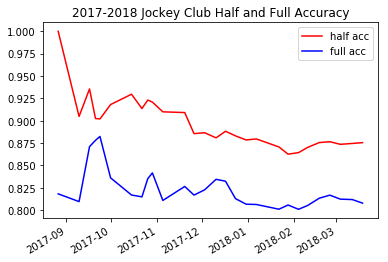

In [263]:
a,b,c = calculateJCWinningAcc(match_table)